In [10]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import requests
%matplotlib inline

In [11]:
def get_playergames(rank=19):
    url = "https://calculated.gg/api/v1/playergames?key=1&rank={}&playlist=13".format(rank)
    r = requests.get(url)
    return r.json()

In [58]:
input_data = None
for rank in range(12, 19):
    for x in range(5):
        rank_data = get_playergames(rank)

        data = pd.DataFrame(rank_data['data'], columns=rank_data['columns']).fillna(0)
        if input_data is not None:
            input_data = input_data.append(data)
        else:
            input_data = data
            
input_data = input_data.reset_index()

In [59]:
input_columns = ['saves', 'total_aerials', 
                 'time_at_boost_speed', 'time_at_slow_speed', 'average_speed', 
                 'boost_usage', 'average_hit_distance', 'ball_hit_forward', 'won_turnovers',
                 'num_stolen_boosts']#
input_columns = list(input_data.columns[11:])
nonzero = input_data[input_data['time_in_game'] > 0]
input = nonzero[input_columns].div(nonzero['time_in_game'], axis=0)
for c in input.columns:
    if (input[c].max()-input[c].min()) == 0:
        input = input.drop(c, axis=1)
input = (input-input.min())/(input.max()-input.min())
output = nonzero['rank'].values.reshape((-1, 1)).astype(float)

In [60]:
threshold = np.random.rand(len(output)) < 0.9
input_train, input_test = input[threshold].values.astype(float), input[~threshold].values.astype(float)
output_train, output_test = output[threshold], output[~threshold]

In [61]:
num_columns = len(input.columns)
n_hidden = 128
class RankPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            nn.Linear(n_hidden//2, n_hidden//4),
            nn.ReLU(),
            nn.Linear(n_hidden//4, 1)
        )
    
    def forward(self, game_state):
        game_state = torch.from_numpy(game_state).float().cuda()
        return self.layers(game_state)

In [68]:
model = RankPredictor().cuda().train()
opt = optim.Adam(model.parameters(), lr=1e-2)
loss = nn.MSELoss()
epochs = 10000
epoch_losses = []
accuracy = []


output_tensor = torch.from_numpy(output_train).float().cuda()

for epoch in range(epochs):
    opt.zero_grad()
    predicted = model(input_train)
    loss_val = loss(predicted, output_tensor)
    loss_val.backward()
    opt.step()
    
    predicted = model(input_test)
    predicted = predicted.cpu().detach().numpy().astype(float)
#     print(predicted.shape, output_test.shape)
#     assert(predicted.shape == output_test.shape)#, "{}, {}".format(predicted.shape, output_test.shape))
    acc = (abs(predicted.astype(float) - output_test.astype(float)) < 3).sum() / predicted.shape[0]
    epoch_losses.append(loss_val.cpu().data.numpy())
    accuracy.append(acc)

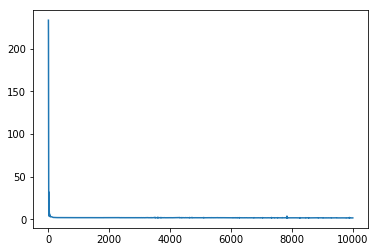

In [69]:
plt.plot(range(len(epoch_losses)), epoch_losses);

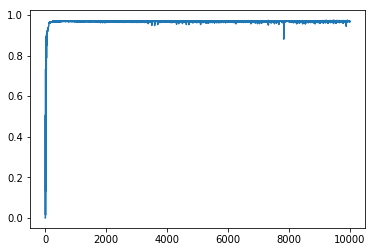

In [70]:
plt.plot(range(len(accuracy)), accuracy);

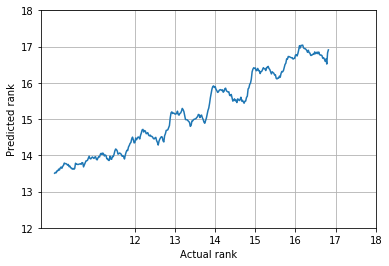

In [75]:
d = []
for x in range(0, len(input_test), 10):
    d.append(model(input_test[x: x+100].astype(float)).mean())
    
plt.plot(np.array(range(len(d))) / 50 + 10, d)
plt.xlabel('Actual rank')
plt.ylabel('Predicted rank')
plt.xticks(list(range(12, 19)))
plt.yticks(list(range(12, 19)));
plt.grid();

In [72]:
input.shape

(35000, 68)

In [73]:
accuracy[8000]

0.9683748169838946

# Ensemble Model

In [79]:
num_columns = len(input.columns)
n_hidden = 128
class RankPredictorEnsemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_columns, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden//2),
            nn.ReLU(),
            nn.Linear(n_hidden//2, n_hidden//4),
            nn.ReLU(),
            nn.Linear(n_hidden//4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, game_state):
        game_state = torch.from_numpy(game_state).float().cuda()
        return self.layers(game_state)

In [77]:
ranks = list(range(10, 20))

In [80]:
models = {}
for rank in ranks:
    models[rank] = RankPredictorEnsemble().cuda()